# Week 4 Project/Challange - Natural Language Processing with Disaster Tweets

### In this notebook we'll develop a model to support a prediction task, categorizing a dataset of tweets as disaster/non-disaster related.

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompati

In [2]:
!pip install tensorflow-text

In [ ]:
!pip install tf-keras
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))
os.environ['TF_USE_LEGACY_KERAS'] = '1'
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or pl

TF_USE_LEGACY_KERAS: None
TF_USE_LEGACY_KERAS: 1


In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### Importing the necessary linraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [7]:
train_df = pd.read_csv("drive/MyDrive/train.csv")
test_df = pd.read_csv("drive/MyDrive/test.csv")

In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Dimensional Analysis

In [9]:
print('Train Dimesions:', train_df.shape)
print('Test Dimesion:', test_df.shape)

Train Dimesions: (7613, 5)
Test Dimesion: (3263, 4)


## Data Preprocessing

Let's start preprocessing by defining a class that will hold the parameters used in data preparation, before the inital steps on model development

Well be using  a minibatch size of 64 for training and a 90%/10% train/val split. Finally, we'll train over 2 epochs.

In [11]:
class PreParams:
  '''
  Class that contains the parameters to be used during
  model development/training
  '''
  N_EXAMPLES = train_df.shape[0]
  VAL_SPLIT = 0.1
  BATCH_SIZE = 64
  STEPS_PER_EPOCH = int(N_EXAMPLES)*(1-VAL_SPLIT) // BATCH_SIZE
  EPOCHS = 2
  AUTO = tf.data.experimental.AUTOTUNE

In [12]:
prep = PreParams()

### Let's now use scikitlearn's train test split to get our training and validation sets

In [13]:
X = train_df['text']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=prep.VAL_SPLIT, random_state=42)

## Model Development

### We'll adopt a transfer learning approach, using the BERT language model. The approach consists on:
- Download the pretrained model on a large dataset
- Fine-tune the model with the given dataset (tweets)



In [14]:
# Load a DistilBERT model.
preset= 'distil_bert_base_en_uncased'

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,sequence_length=160)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
    )

classifier.summary()

100%|██████████| 580/580 [00:00<00:00, 382kB/s]
100%|██████████| 226k/226k [00:00<00:00, 969kB/s]
100%|██████████| 515/515 [00:00<00:00, 359kB/s]
100%|██████████| 253M/253M [00:06<00:00, 44.1MB/s]


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### Let's now compile the model using SparseCategoricalCrossentropy for loss, once we'll be dealing with text in a vectorspace, and finally we'll optmize for accuracy. We'll go with the default optimizer which is RMSprop

In [15]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)


## Model Traning & History

In [16]:
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=prep.BATCH_SIZE,
    epochs=prep.EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/2
108/108 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.7561 - loss: 0.5079 - val_accuracy: 0.8307 - val_loss: 0.4032
Epoch 2/2
108/108 ━━━━━━━━━━━━━━━━━━━━ 101s 931ms/step - accuracy: 0.8671 - loss: 0.3400 - val_accuracy: 0.8294 - val_loss: 0.3989


In [21]:
y_pred = classifier.predict(X_train)

215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step


## F1 Score

In [22]:
tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_pred, axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

print("F1 Score:", f1_score)

F1 Score: 0.885513153019637


## Confusion Matrix

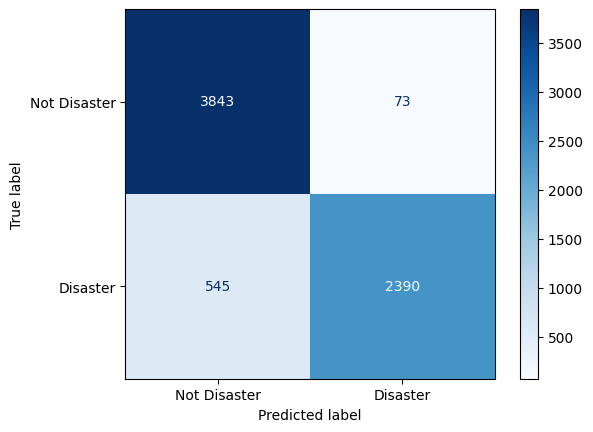

In [19]:
ConfusionMatrixDisplay.from_predictions(
        y_train,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

## Challenge  Submission Set

In [23]:
submission = pd.read_csv('drive/MyDrive/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [26]:
X_test = test_df['text']
test_pred = classifier.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step


In [27]:
target = np.argmax(test_pred, axis=1)
submission['target'] = target
submission.to_csv('submission.csv', index=False)

In [28]:
!cp submission.csv 'drive/My Drive/'

## Conclusion & Future Development

- Transfer learning can greatly reduce development time, taking advantage of pretrained models, on large datasets
-  The BERT model performs well on the proposed task, with a validation accuracy 0.83 and a F1 score og 0.89
- For future development, we could try comparing with vanilla LSTM/RNN architectures from scratch and compare results